# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.  
Известно:  
сalls — количество звонков,  
minutes — суммарная длительность звонков в минутах,  
messages — количество sms-сообщений,  
mb_used — израсходованный интернет-трафик в Мб,  
is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0). 

## Открытие и изучение файла

In [1]:
#Импорт необходимых библиотек
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import warnings
warnings.simplefilter("ignore", UserWarning)
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('C:/Users/Artem/YA_Practicum/datasets/users_behavior.csv')
display(df.head())
display(df.info())

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


None

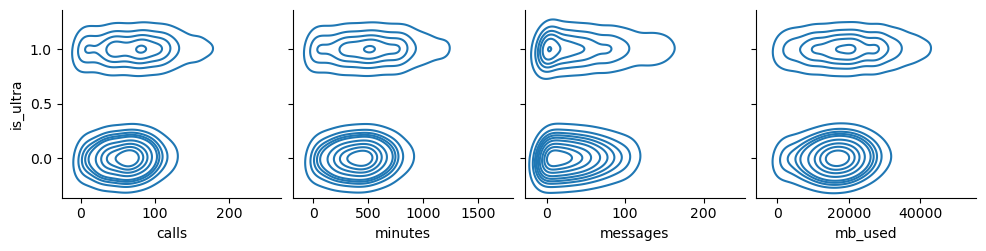

In [3]:
tmp = sns.pairplot(df, kind='kde', x_vars=['calls','minutes','messages','mb_used'], y_vars=['is_ultra'])

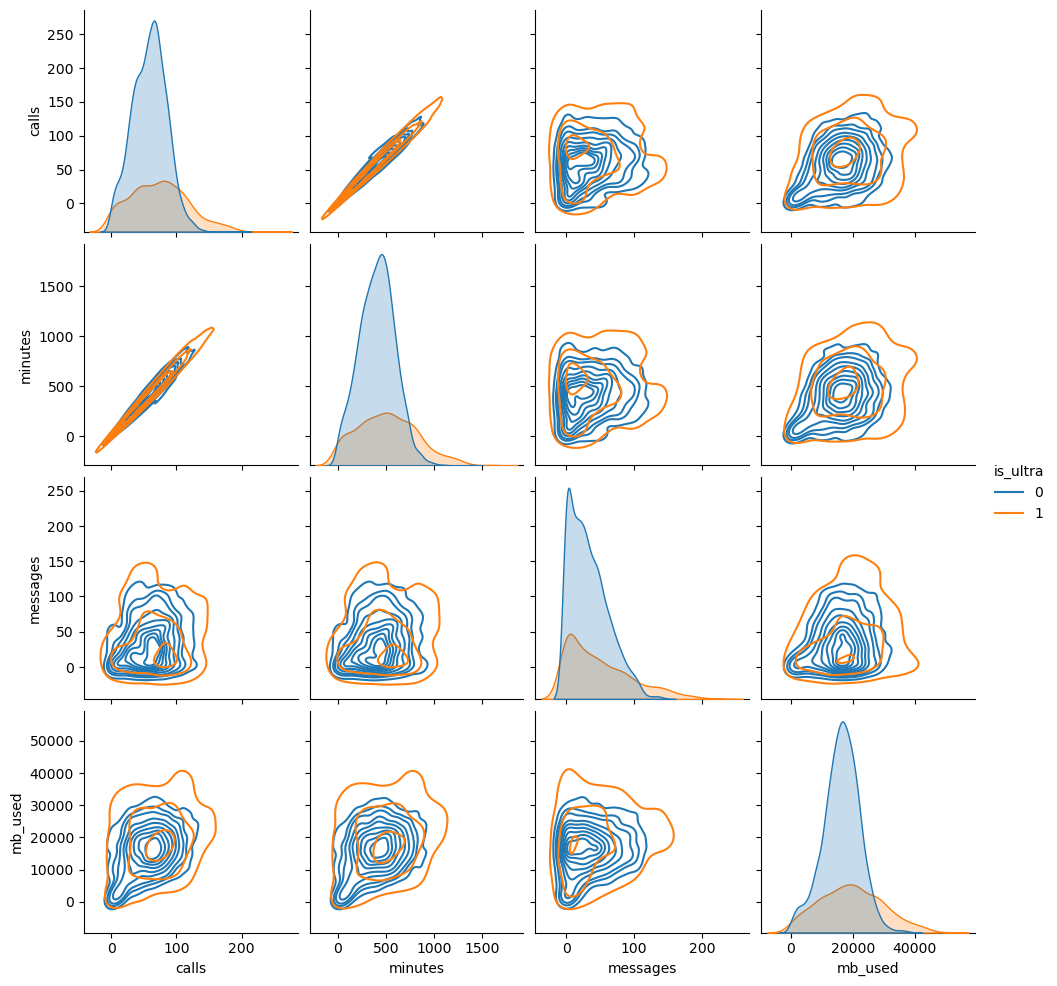

In [4]:
tmp = sns.pairplot(df, hue='is_ultra', kind='kde')

На графиках видна мультиколлинеарность между признаками 'minutes' и 'calls'. Удалим признак 'calls' для улучшения качества обучения

In [5]:
df = df.drop(['calls'], axis=1)

## Разбитие данных на выборки

Разобьем выборку на три части обучающую, валидационную и тестовую, в отношении 3:1:1

In [6]:
df_train_base, df_test = train_test_split(df, test_size=0.2, random_state=12345)
df_train, df_valid = train_test_split(df_train_base, test_size=0.25, random_state=12345)
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

**Размер тестовой выборки** 

In [7]:
print(features_test.shape)
print(target_test.shape)

(643, 3)
(643,)


**Размер обучающей выборки**

In [8]:
print(features_train.shape)
print(target_train.shape)

(1928, 3)
(1928,)


**Размер валидационной выборки**

In [9]:
print(features_valid.shape)
print(target_valid.shape)

(643, 3)
(643,)


## Исследование моделей

**Дерево решений**

In [10]:
best_model = None
best_result = 0
for list_splitter in ['best','random']:
    for list_criterion in ['gini', 'entropy']:
        for depth in range(1, 20):
            model = DecisionTreeClassifier(random_state=12345, max_depth=depth, criterion = list_criterion, splitter=list_splitter)
            model.fit(features_train,target_train) 
            predictions = model.predict(features_valid)
            result = accuracy_score(target_valid,predictions) 
            if result > best_result:
                best_model = model
                best_depth = depth
                best_result = result
                best_criterion = list_criterion
                best_splitter = list_splitter
print("Accuracy лучшей модели дерева решений:", best_result,"Глубина дерева:",  best_depth, "Критерий качества разбиения:", best_criterion, "Стратегия разбиения:", best_splitter)


Accuracy лучшей модели дерева решений: 0.7853810264385692 Глубина дерева: 9 Критерий качества разбиения: entropy Стратегия разбиения: best


**Логистическая регрессия**

In [11]:
best_model = None
best_result = 0
for list_multi_class in ['auto', 'ovr', 'multinomial']:
     for list_max_iter in range(100, 500, 10):
        model = LogisticRegression(random_state=12345, multi_class = list_multi_class, max_iter=list_max_iter)
        model.fit(features_train,target_train) 
        predictions = model.predict(features_valid)
        result = accuracy_score(target_valid,predictions) 
        if result > best_result:
            best_model = model
            best_result = result
            best_multi_class = list_multi_class
            best_max_iter = list_max_iter
            
print("Accuracy лучшей модели логистической регрессии:", best_result,"multi_class:", best_multi_class, "max_iter:", best_max_iter)

Accuracy лучшей модели дерева решений: 0.7262830482115086 multi_class: auto max_iter: 100


**Подбор гиперпараметров для модели логистической регрессии с помощью GridSearchCV**

In [32]:
model_lr = LogisticRegression()
parametrs = {'multi_class': ['auto', 'ovr', 'multinomial'],
                    'max_iter': range (100, 500, 10), 
                    'random_state': [None, 12345]}
clf_lr = GridSearchCV(model_lr, parametrs, n_jobs=-1, cv=5, refit=True, scoring='accuracy')
clf_lr.fit(features_train, target_train)
print('Accuracy лучшей модели логистической регрессии:',clf_lr.best_score_ )
print('Лучшие гиперпараметры для логистической регрессии:', clf_lr.best_params_)


Лучшая accuracy: 0.7505201534217079
Лучшие гиперпараметры для логистической регрессии: {'max_iter': 100, 'multi_class': 'auto', 'random_state': None}


**Модель случайный лес**

In [14]:
best_model = None
best_result = 0
for est in range(1, 11):
    for depth in range(1, 10):
        for samples_leaf in range(1,8):
            for samples_split in range (2,10,2):
                model = RandomForestClassifier(
                random_state=12345, n_estimators=est, max_depth = depth, min_samples_leaf=samples_leaf, min_samples_split=samples_split) 
                model.fit(features_train,target_train) 
                result = model.score(features_valid,target_valid) 
                if result > best_result:
                    best_model = model
                    best_result = result
                    best_depth = depth
                    best_est = est
                    best_samples_leaf = samples_leaf
                    best_samples_split = samples_split
print("Accuracy лучшей модели случайного леса:", best_result, "Количество деревьев", best_est, "Глубина:",best_depth, "минимальное число образцов в листах", best_samples_leaf, "минимальное число образцов для сплита",best_samples_split)

Accuracy лучшей модели случайного леса: 0.8009331259720062 Количество деревьев 2 Глубина: 7 минимальное число образцов в листах 2 минимальное число образцов для сплита 6


In [20]:
model = RandomForestClassifier(random_state=12345, n_estimators=2, max_depth=7, min_samples_leaf=2, min_samples_split=6) 
model.fit(features_train,target_train) 
result = model.score(features_valid,target_valid) 
print("Accuracy лучшей модели случайного леса:", result)

Accuracy лучшей модели случайного леса: 0.8009331259720062


**Подбор гиперпараметров для модели случайного леса с помощью GridSearchCV**

In [30]:
model_RFC = RandomForestClassifier()
parametrs_RFC = { 'n_estimators': range (1, 11),
              'max_depth': range (1,10),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }
clf_RFC = GridSearchCV(model_RFC, parametrs_RFC,scoring='accuracy', cv=5)
clf_RFC.fit(features_train, target_train) 
best_model_RFC_GSCV = clf_RFC.best_estimator_
print('Лучшая accuracy:',clf_RFC.best_score_ )
print('Лучшие гиперпараметры для модели случайного леса:', clf_RFC.best_params_)

Best accuracy: 0.8200255702846377
Лучшие гиперпараметры для модели случайного леса: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 10}


**Промежуточный вывод**

Лучше всего показала себя модель случайного леса с гипперпараметрами количеством деревьев равным 10, глубиной 7, минимальным числом образцов в листах 4, минимальным числом образцов для сплита 4 подобранными с помощью GridSearchCV и Accuracy равным 0.82

## Проверка модели на тестовой выборке

In [31]:
predictions_test_rfc = best_model_RFC_GSCV.predict(features_test)
result_test_rfc = accuracy_score(predictions_test_rfc, target_test)
print('Accuracy RandomForestClassifier:', result_test_rfc)

Accuracy RandomForestClassifier: 0.7931570762052877


Accuracy у модели случайного леса на тестовой выборке равна 0.793

## Проверка модели на адекватность

In [22]:
model_dc = DummyClassifier(strategy='most_frequent', random_state=12345)
model_dc.fit(features_train, target_train)
result_dc = model_dc.score(features_valid, target_valid)
print('Accuracy DummyClassifier:', result_dc)

Accuracy DummyClassifier: 0.6889580093312597


Accuracy модели DummyClassifier ниже, чем у модели RandomForestClassifier - модель адекватна.

## Вывод

В данном проекте мы рассмотрели три модели DecisionTreeClassifier, LogisticRegression, RandomForestClassifier.    
-Датафрейм был разделен на обучающую, тестовую и валидационную выборки в отношении 3:1:1.

-GridsearchCV показал себя наилучшим образом для подбора лучших гипперпараметров.

-Наилучшим образом показала себя модель RandomForestClassifier с гиперпараметрами n_estimators=10, max_depth=7, min_samples_leaf=4, min_samples_split=4. Accuracy на тестовой выборке составила 0.793 

-Адекватность модели проверена с помощью модели DummyClassifier на тестовой выборке. Accuracy составила: 0.689
